1) Скачать датасет https://github.com/phelber/EuroSAT?tab=readme-ov-file
2) Используя ArcFace Loss обучить нейронку (Resnet18) кодировать изображения  одного класса похожим образом (всего 10 классов ~3000 изображений на класс)
3) С помощью t-SNE визуализировать результаты работы (использовать тестовый датасет)
4) Визуализировать результаты работы (inference) в виде - пара изображений + distance

In [103]:
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np
import cv2

(64, 64, 3)


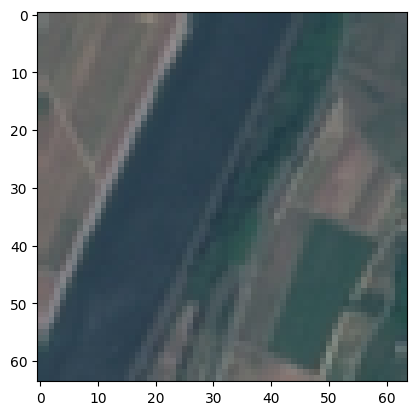

In [62]:
image = Image.open('dataset/River/River_1.jpg').convert("RGB")
plt.imshow(image)
print (np.array(image).shape)

In [120]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)  # List of class folders
        self.image_paths = []  # List of (image path, class index) tuples

        for class_id, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpg"):
                    self.image_paths.append((os.path.join(class_dir, image_name), class_id, class_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, class_id, class_name = self.image_paths[idx]

        image = Image.open(image_path).convert('RGB')  # Convert to RGB if not already

        if self.transform:
            image = self.transform(image)

        return image, class_id, class_name

In [121]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # make sure the shape is (64, 64, 3)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize
])

dataset = ImageDataset(root_dir='dataset', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device='cuda:0')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, pin_memory_device='cuda:0')

In [122]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print (torch.cuda.is_available())

True


/root/projects/2_lab_3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/projects/2_lab_3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [123]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin=0.5, scale=64.0):
        super(ArcFaceLoss, self).__init__()
        self.margin = margin
        self.scale = scale
        self.weights = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weights)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings, p=2, dim=1).to(device)
        weights = F.normalize(self.weights, p=2, dim=1).to(device)

        logits = F.linear(embeddings, weights)
        return logits

In [124]:
num_classes = 10
embedding_size = 128
num_epochs = 10

criterion = ArcFaceLoss(num_classes, embedding_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        embeddings = model(images).to(device)
        logits = criterion(embeddings, labels)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(logits, 1)  # get predicted class labels
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch [1/10], Loss: 1.5890, Accuracy: 0.8279
Epoch [2/10], Loss: 1.5198, Accuracy: 0.8981
Epoch [3/10], Loss: 1.5021, Accuracy: 0.9166
Epoch [4/10], Loss: 1.4912, Accuracy: 0.9293
Epoch [5/10], Loss: 1.4821, Accuracy: 0.9387
Epoch [6/10], Loss: 1.4776, Accuracy: 0.9435
Epoch [7/10], Loss: 1.4736, Accuracy: 0.9481
Epoch [8/10], Loss: 1.4659, Accuracy: 0.9563
Epoch [9/10], Loss: 1.4604, Accuracy: 0.9624
Epoch [10/10], Loss: 1.4595, Accuracy: 0.9626


In [134]:
embeddings = []
labels_show = []
model.eval()
with torch.no_grad():
    for images, labels, label_names in test_loader:
        images = images.to(device)
        embeddings.append(model(images).cpu().numpy())
        labels_show.append(label_names)

embeddings = np.concatenate(embeddings)

print((tuple (label) for label in labels_show))

tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(embeddings)

<generator object <genexpr> at 0x7ff5d0b0e4d0>


In [135]:
torch.save(model, 'arcfacetask.pth')
print("Model saved to: arcfacetask.pth")

Model saved to: arcfacetask.pth


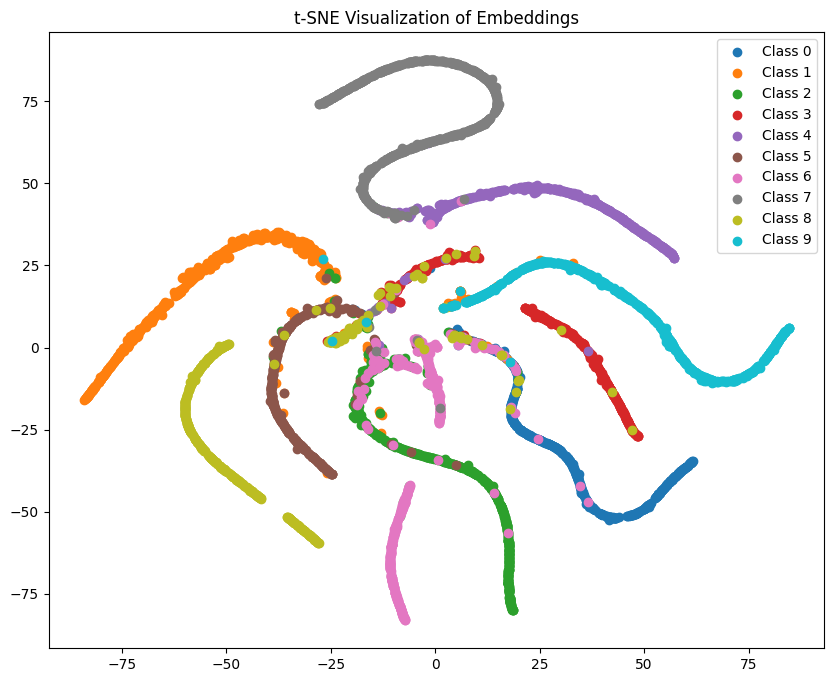

In [ ]:
plt.figure(figsize=(10, 8))
for label in labels_show.unique():
    plt.scatter(embeddings[labels_show == label, 0], embeddings[labels == label, 1], label=f"Class {label}")
plt.legend()
plt.title("t-SNE Visualization of Embeddings")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3644148..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0561693..1.0365143].


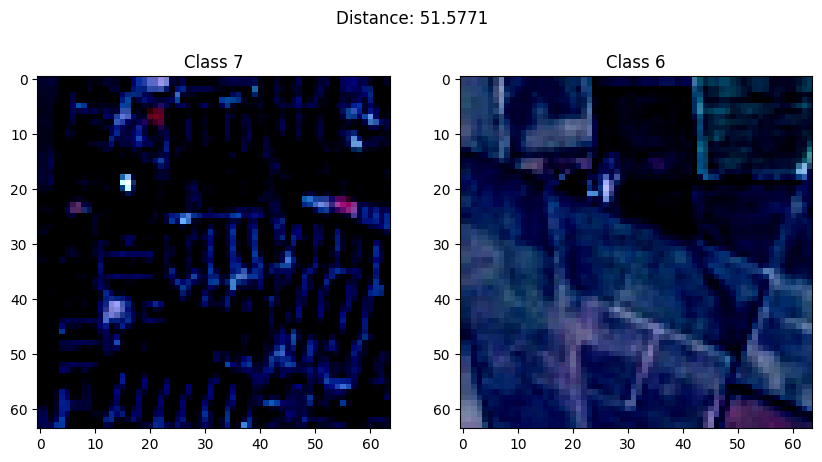

In [101]:
image1, label1 = random.choice(test_dataset)
image2, label2 = random.choice(test_dataset)

# embeddings
with torch.no_grad():
    embedding1 = model(image1.unsqueeze(0).to(device))
    embedding2 = model(image2.unsqueeze(0).to(device))

# euclidean distance
distance = torch.norm(embedding1 - embedding2).item()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.permute(1, 2, 0))
plt.title(f"Class {label1}")

plt.subplot(1, 2, 2)
plt.imshow(image2.permute(1, 2, 0))
plt.title(f"Class {label2}")

plt.suptitle(f"Distance: {distance:.4f}")
plt.show()